In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### 1. Sequential Feature Selector - жадный алгоритм выбора фич

Ссылка на описание: https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

Входит в библиотеку mlxtend

***Принцип работы:*** мы выбираем какой-то базовый алгоритм. К примеру, SVM.
После этого мы запускаем первую итерацию цикла: перебираем все фичи, что у нас есть в датасете, и на каждой обучаем алгоритм. Замеряем качество алгоритма кросс-валидацией. После того, как мы попробовали обучить алгоритм на каждой из фич по отдельности, мы смотрим, какая фича показала лучший результат - её мы добавляем в наше подмножество "лучших фич"
Вторым шагом - делаем тоже самое, только уже прибавляя какую-то фичу к выбранной на первом шаге, то есть по сути выбираем лучший вариант из двух фич, одна из которых - выбранная на первом шаге

И далее аналогично

In [2]:
!pip install mlxtend

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [74]:
### загружаем данные и создаем классификатор

from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target
knn = KNeighborsClassifier(n_neighbors=4)

In [8]:
### выбираем фичи. Вот что значат параметры класса
### 1) k_features - количество фич, до которого вы хотите сделать перебор
### К примеру, у вас есть 100 фич. Вы хотите выбрать алгоритмом оптимальный вариант из 20 фич, тогда k_features=20
### 2) forward - способ перебора. Дело в том, что есть еще один способ перебора, помимо вышеописанного - когда мы начинаем
### со всех возможных фич и убираем по одной, то есть уменьшаем их число на 1, так чтобы скор был лучший.
### 3) floating - дополнительный просмотр в противоположную сторону от направления forward
### В этом случае параметр forward=False, а при переборе, который начинается с 0 - True.
### 4) verbose=2 - это для принта промежуточных результатов, которые получаются у алгоритма
### 5) scoring - функция, по которой будет замеряться качество. К сожалению, можно выбрать только одну из тех, что 
### реализованы в библиотеке, но там есть большинство популярных метрик
### 6) cv - параметр, который говорит, на сколько фолдов надо делить для вычисления качества алгоритмов на кросс-валидации

### Более подробное описание и нюансы можно глянуть в документации библиотеки


sfs1 = SequentialFeatureSelector(knn, 
           k_features=3, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=4)

sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2018-04-07 21:52:10] Features: 1/3 -- score: 0.952991452991[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2018-04-07 21:52:10] Features: 2/3 -- score: 0.959935897436[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2018-04-07 21:52:10] Features: 3/3 -- score: 0.972756410256

In [10]:
### k_feature_idx_ - здесь после завершения работы алгоритма остаются тот набор фич, который оказался оптимальным
sfs1.k_feature_idx_

(1, 2, 3)

In [15]:
### subsets_ - здесь сохраняется вся возможная информация о ходе работы алгоритма

sfs1.subsets_

{1: {'avg_score': 0.95299145299145294,
  'cv_scores': array([ 0.97435897,  0.94871795,  0.88888889,  1.        ]),
  'feature_idx': (3,)},
 2: {'avg_score': 0.95993589743589736,
  'cv_scores': array([ 0.97435897,  0.94871795,  0.91666667,  1.        ]),
  'feature_idx': (2, 3)},
 3: {'avg_score': 0.97275641025641035,
  'cv_scores': array([ 0.97435897,  1.        ,  0.94444444,  0.97222222]),
  'feature_idx': (1, 2, 3)}}

### 2. Exhaustive Feature Selector - перебор подмножеств фич

In [17]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector


### min_features - минимальное количество признаков, из которого должно состоять подмножество
### max_features - максимальное количество признаков, из которого должно состоять подмножество
efs1 = ExhaustiveFeatureSelector(knn, 
           min_features=1,
           max_features=4,
           scoring='accuracy',
           print_progress=True,
           cv=5)

efs1 = efs1.fit(X, y)

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset:', efs1.best_idx_)

Features: 15/15

Best accuracy score: 0.97
Best subset: (0, 1, 2, 3)


**Итоги:**

- Exhaustive находит лучшее сочетание фич, но требует обучение моделей порядка 2 в степени N умноженное на cv, где N - количество признаков, а cv - количество фолдов

- Sequintial не находит абсолютно лучшее сочетание, но действует в соответствии с неплохой логикой и требует обучение только ~N*cv моделей

- В качестве базовой модели нужно выбирать достаточно легкую и быструю, но качествунную. Если у вас получаются хорошие результаты на ансамблевых моделях, можно попробовать RandomForrest. LogisticRegression может так же обучаться быстро.

- 

### 3. TSNE - визуализация многоразмерных пространств на плоскости

Основная идея - сохранить пропорции расстояний между объектами

In [18]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [75]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


tsne = TSNE(random_state=1)
tsne_representation = tsne.fit_transform(X_scaled)

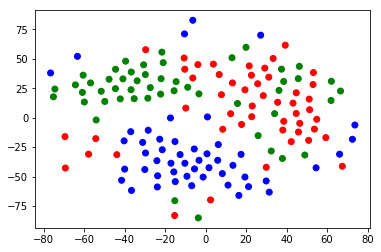

In [29]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=pd.Series(y).map({0: 'blue', 1: 'red', 2: 'green'}))

In [30]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


tsne = TSNE(random_state=1)
tsne_representation = tsne.fit_transform(X_scaled)

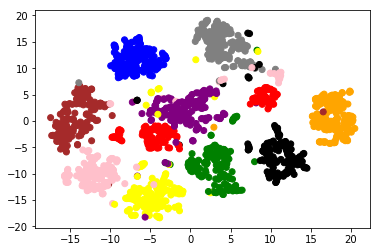

In [35]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=pd.Series(y).map({0: 'blue', 1: 'red', 2: 'green', 3: 'yellow', 4: 'black', 5: 'brown', 6: 'orange', 7: 'grey',
                               8: 'purple', 9: 'pink'}));

### 4. Направленный поиск гиперпараметров - hyperopt

Ссылка: https://github.com/hyperopt/hyperopt/wiki/FMin

In [4]:
#!pip install hyperopt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

In [5]:
import catboost
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

In [7]:
y.shape

(569,)

In [20]:
### сначала создаем функцию score
def score(params):
    print('Params: ')
    print(params)
    rfc = RandomForestClassifier(**params)
    score = cross_val_score(rfc, X, y)
    print ("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

def optimize(trials):
    space = {
        'n_estimators': hp.randint('n_estimators', 20)
    }
    ### далее вы передаете это пространство гиперпараметров и функция, по которой нужно считать score функции fmin.
    ### max_evals - максимальное количество итераций поиска
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20)
    print(best)

In [23]:
rfc = RandomForestClassifier()
score = cross_val_score(rfc, X, y)

In [22]:
trials = Trials()
optimize(trials)

TypeError: 'numpy.ndarray' object is not callable

### 5. Практика - попробуем применить всё что мы сейчас изучили на каком-нибудь задании